# Regression
Let's go back to our weather dataset. Instead of the binary `BBQ_weather` label we could try to predict a continuous value. In this chapter we will focus on predicting the number of sunshine hours in Basel based on the previous day.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('data/weather_prediction_dataset.csv')
data.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,SONNBLICK_temp_mean,SONNBLICK_temp_min,SONNBLICK_temp_max,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-15.2,-17.0,-13.4,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,-13.7,-15.0,-12.3,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-9.2,-12.5,-5.8,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,-5.6,-7.0,-4.2,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-7.6,-9.4,-5.8,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


### Exercise
Before you can apply machine learning, you will first have to identify the inputs and outputs to the algorithm. What will be the inputs in this case, and what will be the output?

Does our dataset have everything need or do we need to apply additional preprocessing?

#### Answer
We need to create a column that shows the number of sunshine hours for the next day

We will have to select our 3 years of data again. Then we create a new column that will show the number of sunshine hours in Basel on the next day.

In [3]:
n_rows = 365*3
weather_3years = data[:n_rows].drop(columns=['DATE', 'MONTH'])
sunshine_tomorrow = data[1:n_rows + 1]['BASEL_sunshine'].values

sunshine_tomorrow.mean()

4.531780821917808

We will have to split our training and test set again:

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(weather_3years.values, sunshine_tomorrow, test_size=0.3, random_state=0)

We will have to normalize the input again as well

Now that we have prepared our data we can start training our classifier. Let's start with a simple linear regression model.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [6]:
pipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('model', LinearRegression()),
])

In [7]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', MinMaxScaler()), ('model', LinearRegression())])

This time we can't use a confusion matrix to check our model so we have to use different methods to compare performance.

In these cases we usually plot the predictions against the ground truth to get a feeling.

In [8]:
pred_train= pipe.predict(X_train)
pred_test= pipe.predict(X_test)

<AxesSubplot:title={'center':'Performance on training set'}, xlabel='ground truth', ylabel='prediction'>

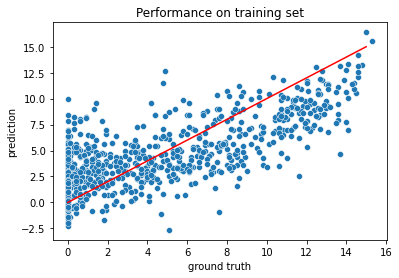

In [9]:
import matplotlib.pyplot as plt

plot = sns.scatterplot(x=y_train, y=pred_train)
plot.set_title('Performance on training set')
plot.set_xlabel('ground truth')
plot.set_ylabel('prediction')
plot.set_xbound((0, 16))
plot.set_ybound((-3, 16))

sns.lineplot(x=np.arange(16), y=np.arange(16), color='red')

<AxesSubplot:title={'center':'Performance on test set'}, xlabel='ground truth', ylabel='prediction'>

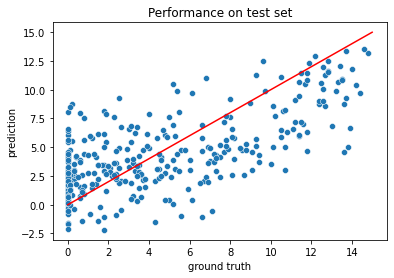

In [10]:
plot = sns.scatterplot(x=y_test, y=pred_test)
plot.set_title('Performance on test set')
plot.set_xlabel('ground truth')
plot.set_ylabel('prediction')
plot.set_xbound((0, 16))
plot.set_ybound((-3, 16))

sns.lineplot(x=np.arange(16), y=np.arange(16), color='red')

We can also have a look at performance metrics like mean squared error and mean absolute error. The advantage of mean absolute error is that it is expressed in the same units as the prediction values.

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

display(f'MSE train {mean_squared_error(y_train, pred_train)} MAE train: {mean_absolute_error(y_train, pred_train)}')
display(f'MSE test {mean_squared_error(y_test, pred_test)} MAE test: {mean_absolute_error(y_test, pred_test)}')

'MSE train 8.97647473137586 MAE train: 2.417082765676909'

'MSE test 10.599978336514575 MAE test: 2.610255855653187'

It is hard to say whether our results are good or bad. This depends on whether our prediction problem is hard or easy.

One way to evaluate can be to think of a very simple model and compare it against that.

### Exercise
Any ideas what could serve as a baseline model?

#### Answer
One idea could be to use the number of sunshine hours of the current day to predict the sunshine hours the next day. Consecutive days can have similar weather, right?

'Baseline MSE: 19.36031331592689'

'Predicted MSE: 8.97647473137586'

'Baseline MSE: 16.64887537993921'

'Predicted MSE: 10.599978336514575'

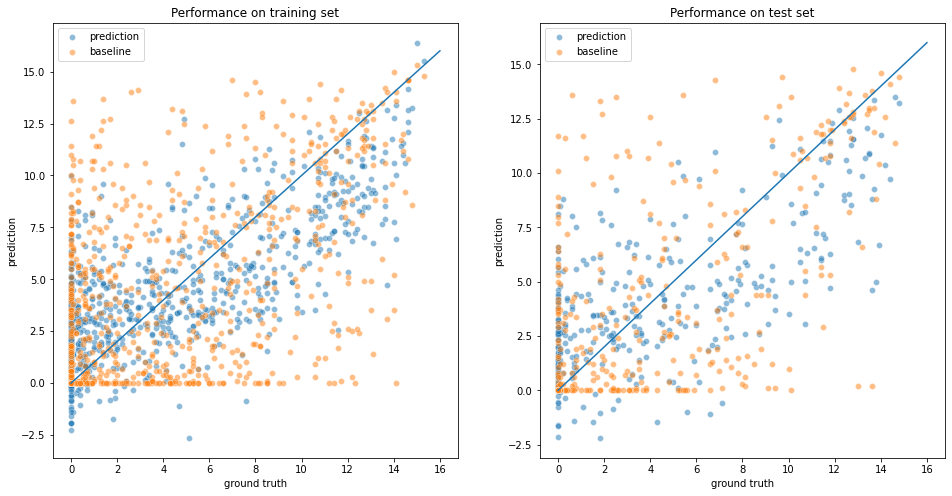

In [12]:
baseline_idx = weather_3years.columns.get_loc('BASEL_sunshine')

baseline_train = X_train[:, baseline_idx]
baseline_test = X_test[:, baseline_idx]

def plot_against_baseline(ground_truth, predicted, baseline, axis=None, label=''):
    plot = sns.scatterplot(x=ground_truth, y=predicted, label='prediction', alpha=0.5, ax=axis)
    plot.set_title(label)
    plot.set_xlabel('ground truth')
    plot.set_ylabel('prediction')
    plot.set_xbound((0, 16))
    plot.set_ybound((-3, 16))

    #sns.lineplot(x=np.arange(16), y=np.arange(16), color='red')
    sns.scatterplot(x=ground_truth, y=baseline, label='baseline', alpha=0.5, ax=axis)
    sns.lineplot(x=[0, 16], y=[0,16], ax=axis)
    display(f'Baseline MSE: {mean_squared_error(ground_truth, baseline)}')
    display(f'Predicted MSE: {mean_squared_error(ground_truth, predicted)}')


fig, axes = plt.subplots(1, 2, figsize=(16, 8))
plot_against_baseline(y_train, pred_train, baseline_train, axis=axes[0], label='Performance on training set')
plot_against_baseline(y_test, pred_test, baseline_test, axis=axes[1], label='Performance on test set')

As we can see, the baseline looks even more scatered than our prediction.



## Neural network
Let's create a non-linear model now. A well-known nonlinear model is the *neural network*. There are many libraries that are solely focused on neural networks, but we will not go into that today.

Scikit learn has the capability to create fairly simple neural networks. Let's create a model pipeline with a neural network!

We will use the class `MLPRegressor` for this. MLP stands for multi-layer perceptron.

Let's swap out our linear regression model for a neural network.

In [13]:
from sklearn.neural_network import MLPRegressor

neural_network = MLPRegressor()

layer_sizes = neural_network.hidden_layer_sizes

display(f'Hidden layer sizes: {layer_sizes},  number of layers: {len(layer_sizes)}')

'Hidden layer sizes: (100,),  number of layers: 1'

Let's plug our network into our training pipeline

In [14]:
layer_sizes = (100, ) * 2

neural_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('network', MLPRegressor(hidden_layer_sizes=layer_sizes))
])

In [15]:
neural_pipe.fit(X_train, y_train)

/home/dsmits/anaconda3/envs/SICSS/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('network', MLPRegressor(hidden_layer_sizes=(100, 100)))])

'Baseline MSE: 19.36031331592689'

'Predicted MSE: 6.922111948305572'

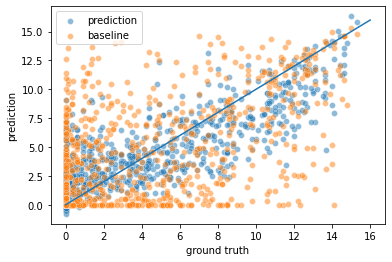

In [16]:
nn_train_pred = neural_pipe.predict(X_train)
nn_test_pred = neural_pipe.predict(X_test)

plot_against_baseline(y_train, nn_train_pred, baseline_train)

'Baseline MSE: 16.64887537993921'

'Predicted MSE: 10.723057494806332'

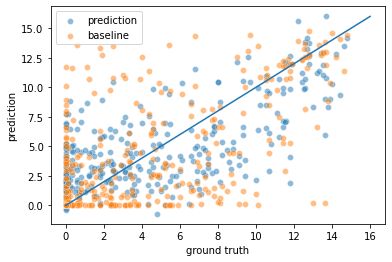

In [17]:
plot_against_baseline(y_test, nn_test_pred, baseline_test)

### Exercise
Play around with the hidden layer sizes and number of layers. How does it affect the performance on the training and test set?

#### Answer
Using 10 layers of 100 nodes will drastically improve performance on the training set, but reduce peformance on the test set. A clear sign of overfitting.

## Saving your model
Suppose you like the performance of your model. You would like to save it for later use. This can be done as follows.

In [18]:
import pickle

with open('neural_model.pkl', 'wb') as f:
    pickle.dump(neural_pipe, f)

In [19]:
with open('neural_model.pkl', 'rb') as f:
    neural_pip = pickle.load(f)

## Other regression models
### Exercise
Check the [scikit learn documentation](https://scikit-learn.org/stable/supervised_learning.html) for other regression models.

Pick an algorithm and swap out your MLPRegressor for that one.

- How does it perform on the training and test set?
- Is it overfitting, or not?
- Read the documentation on your chosen algorithm. Can you gain an intuition why this model performs the way it does?

Some suggestions:
- [Nearest neighbor regression](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor)
- [Random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

Tip: You can automate some parts of your model evaluation:

In [31]:
def evaluate_model(regressor):
    pipeline = Pipeline([('scaler', MinMaxScaler()), ('regressor', regressor)])    
    pipeline.fit(X_train, y_train)
    
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    display('Training')
    plot_against_baseline(y_train, pred_train, baseline_train, axis=axes[0], label='Performance on training set')
    display('Test')
    plot_against_baseline(y_test, pred_test, baseline_test, axis=axes[1], label='Performance on test set')

'Training'

'Baseline MSE: 19.36031331592689'

'Predicted MSE: 1.5238387167101815'

'Test'

'Baseline MSE: 16.64887537993921'

'Predicted MSE: 10.414338686930092'

'Training'

'Baseline MSE: 19.36031331592689'

'Predicted MSE: 8.863408355091385'

'Test'

'Baseline MSE: 16.64887537993921'

'Predicted MSE: 13.072544680851065'

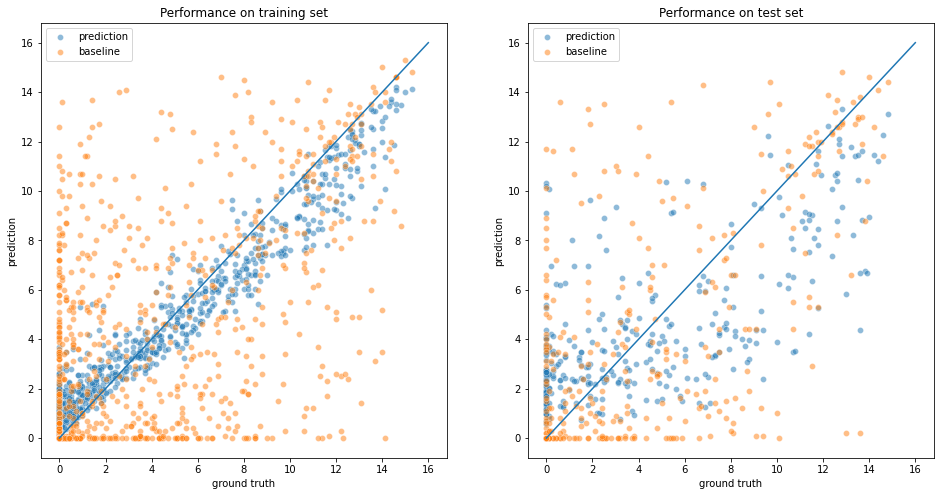

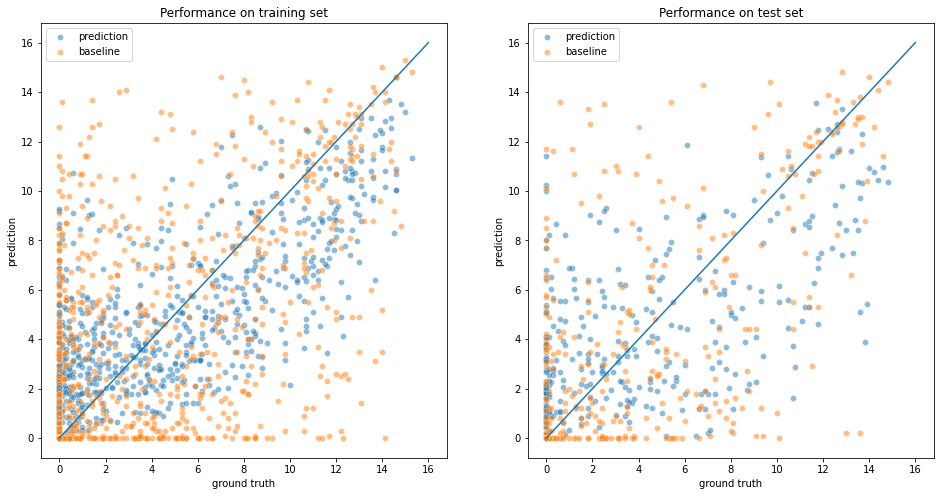

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

evaluate_model(RandomForestRegressor())
evaluate_model(KNeighborsRegressor())